# Hyperparameter Tuning for SVM Classifier
**Prepared by:** Yongli Chen and Adisorn Promkaewngarm

# Import Library

In [ ]:
!pip -q install mplfinance

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, loguniform
import mplfinance as mpf

# Import Data

In [ ]:
# GitHub Raw Data Paths
path_feature = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_SET_features_weekly.csv'
path_label_train = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_regime_labeling_traindata_weekly.csv'
path_set_data = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_Index_Weekly_2010_2025.csv'

# 1. Load the feature set
df_features = pd.read_csv(path_feature, index_col=0, parse_dates=True)

  # Train-Test split by period
df_features_train = df_features.loc[df_features.index.year < 2023].copy()
df_features_train = df_features_train.iloc[:, 1:] # Remove currnet return
df_features_train = df_features_train[[
    col for col in df_features_train.columns
    if 'lag' not in col or int(col.split('lag')[-1].replace('_', '')) <= 12
]]   # Filter to get only lag1 to lag12

  # Train-Test split by period
df_features_test = df_features.loc[df_features.index.year >= 2023,].copy()
df_features_test = df_features_test.iloc[:, 1:] # Remove currnet return
df_features_test = df_features_test[[
    col for col in df_features_test.columns
    if 'lag' not in col or int(col.split('lag')[-1].replace('_', '')) <= 12
]] # Filter to get only lag1 to lag12

# 2. Load the training labels
df_labels = pd.read_csv(path_label_train, index_col=0, parse_dates=True)
df_labels_train = df_labels['Regime_ID'].copy()

# 3. Load the raw SET Index OHLC data
df_set_index = pd.read_csv(path_set_data, index_col=0, parse_dates=True)

In [ ]:
# 1. Check Training Set Alignment (Features vs. GM-HMM Labels)
train_indices_match = df_features_train.index.equals(df_labels_train.index)

# Define df_set_index_test here to resolve NameError
df_set_index_test = df_set_index.loc[df_set_index.index.year >= 2023].copy()

# 2. Check Testing Set Alignment (Features vs. Raw SET Index)
test_indices_match = df_features_test.index.equals(df_set_index_test.index)

# 3. Print Results
print("="*50)
print("INDEX CONSISTENCY VERIFICATION")
print("="*50)
print(f"Training Set Indices Match: {train_indices_match}")
print(f"Testing Set Indices Match:  {test_indices_match}")
print("-" * 50)

# If they don't match, let's see where the discrepancy is
if not train_indices_match:
    print(f"Training Features: {len(df_features_train)} rows")
    print(f"Training Labels:   {len(df_labels_train)} rows")
    # Finding the difference
    diff = df_features_train.index.difference(df_labels_train.index)
    print(f"Missing dates in labels: {len(diff)}")

if not test_indices_match:
    print(f"Testing Features:  {len(df_features_test)} rows")
    print(f"Testing SET Data:  {len(df_set_index_test)} rows")
print("="*50)

INDEX CONSISTENCY VERIFICATION
Training Set Indices Match: True
Testing Set Indices Match:  True
--------------------------------------------------


# Data Normalization

In [ ]:
# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit and Transform the Training Data
X_train_scaled = scaler.fit_transform(df_features_train)

# 3. Transform the Testing Data (using the training parameters)
X_test_scaled = scaler.transform(df_features_test)

# Convert back to DataFrame to maintain column names for XGBoost
X_train_final = pd.DataFrame(X_train_scaled, index=df_features_train.index, columns=df_features_train.columns)
X_test_final = pd.DataFrame(X_test_scaled, index=df_features_test.index, columns=df_features_test.columns)

# Hyperparameter Tuning

In [ ]:
print("="*50)
print("REVISED SVM: CLAMPED FOR GENERALIZATION")
print("="*50)

# Set to True to run hyperparameter tuning
run_svm_tuning = False

# Options: 'accuracy' or 'f1_macro'
scoring_metric = 'accuracy' # Our trial show accuray is better

if run_svm_tuning:
    # 1. Setup Base SVM Classifier
    svm_clf = SVC(
        random_state=42,
        probability=True,
        class_weight='balanced',
        cache_size=1000
    )

    # 2. ANTI-MEMORIZATION Parameter Distribution
    # We restrict C and gamma to stop the "Diagonal Line" memorization trap.
    param_dist_svm = [
        {
            'kernel': ['rbf'],
            # Hard Ceiling on C: Max 10.0 forces the SVM to ignore specific row patterns.
            'C': loguniform(1e-2, 10),
            # Restricted Gamma: Prevents the model from creating tiny "islands" around points.
            'gamma': ['scale', 'auto'] + [0.0001, 0.001],
            'shrinking': [True]
        },
        {
            'kernel': ['linear'],
            # Linear is the ultimate defense against temporal memorization.
            'C': loguniform(1e-3, 1),
            'shrinking': [True]
        },
        {
            'kernel': ['poly'],
            'C': loguniform(1e-2, 1),
            'degree': [2],
            'gamma': ['scale'],
            'shrinking': [True]
        }
    ]

    tscv = TimeSeriesSplit(n_splits=5)
    n_iter_svm = 30

    random_search_svm = RandomizedSearchCV(
        estimator=svm_clf,
        param_distributions=param_dist_svm,
        n_iter=n_iter_svm,
        cv=tscv,
        scoring=scoring_metric, # Switched based on variable above
        verbose=2,
        n_jobs=-1,
        random_state=42,
        refit=True,
        error_score='raise'
    )

    print(f"\nStarting Search: {n_iter_svm} iterations (Metric: {scoring_metric})")
    print(f"Applying Clamped Regularization to prevent temporal memorization...")
    print("-" * 50)

    # Display Class Distribution
    class_counts = pd.Series(df_labels_train).value_counts().sort_index()
    for cls, count in class_counts.items():
        name = {0: 'Sideways', 1: 'Bull', 2: 'Bear'}.get(cls, f"Class {cls}")
        print(f"  {name}: {count} samples ({count/len(df_labels_train)*100:.1f}%)")

    start_time = time.time()
    random_search_svm.fit(X_train_final, df_labels_train)
    duration = time.time() - start_time

    # --- FINAL BEST PARAMETER OUTPUT (OOT) ---
    if random_search_svm.best_params_:
        print("\n" + "="*50)
        print("WINNING SVM HYPERPARAMETERS (OUT OF TUNING)")
        print("="*50)

        # Iterating through the dictionary to print nicely
        for param, value in random_search_svm.best_params_.items():
            print(f"{param.upper():15}: {value}")

        print("-" * 50)
        print(f"Best CV {scoring_metric.capitalize()}: {random_search_svm.best_score_:.4f}")
        print(f"Total Tuning Time: {duration/60:.2f} minutes")
        print("="*50)

        # Set the best model for later use
        best_svm_model = random_search_svm.best_estimator_

        # --- QUICK BIAS CHECK ---
        y_temp_pred = best_svm_model.predict(X_train_final)
        pred_counts = pd.Series(y_temp_pred).value_counts().to_dict()
        print("\nFinal Model Prediction Distribution (Training Set):")
        for cls in [0, 1, 2]:
            name = {0: 'Sideways', 1: 'Bull', 2: 'Bear'}[cls]
            print(f"  {name}: {pred_counts.get(cls, 0)} predictions")

else:
    print("Skipping SVM tuning.")

REVISED SVM: CLAMPED FOR GENERALIZATION
Skipping SVM tuning.



WINNING SVM HYPERPARAMETERS (OUT OF TUNING)



C              : 0.2115429079726121

KERNEL         : 'linear'

SHRINKING      : True

# Model Training

In [ ]:
if not run_svm_tuning:
    from sklearn.svm import SVC

    # Initialize the SVM with your optimized parameters
    best_svm_model = SVC(
            C=0.2115429079726121,
            cache_size=1000,
            class_weight='balanced',
            shrinking=True,
            tol=0.001,
            kernel='linear',
            probability=True,
            random_state=42
            )

    # Fit the model
    best_svm_model.fit(X_train_final, df_labels_train)


SVM Training Set Performance (2011-2022):
--------------------------------------------------
              precision    recall  f1-score   support

    Sideways       0.55      0.66      0.60       249
        Bear       0.41      0.28      0.34       201
        Bull       0.51      0.54      0.52       176

    accuracy                           0.51       626
   macro avg       0.49      0.50      0.49       626
weighted avg       0.49      0.51      0.49       626



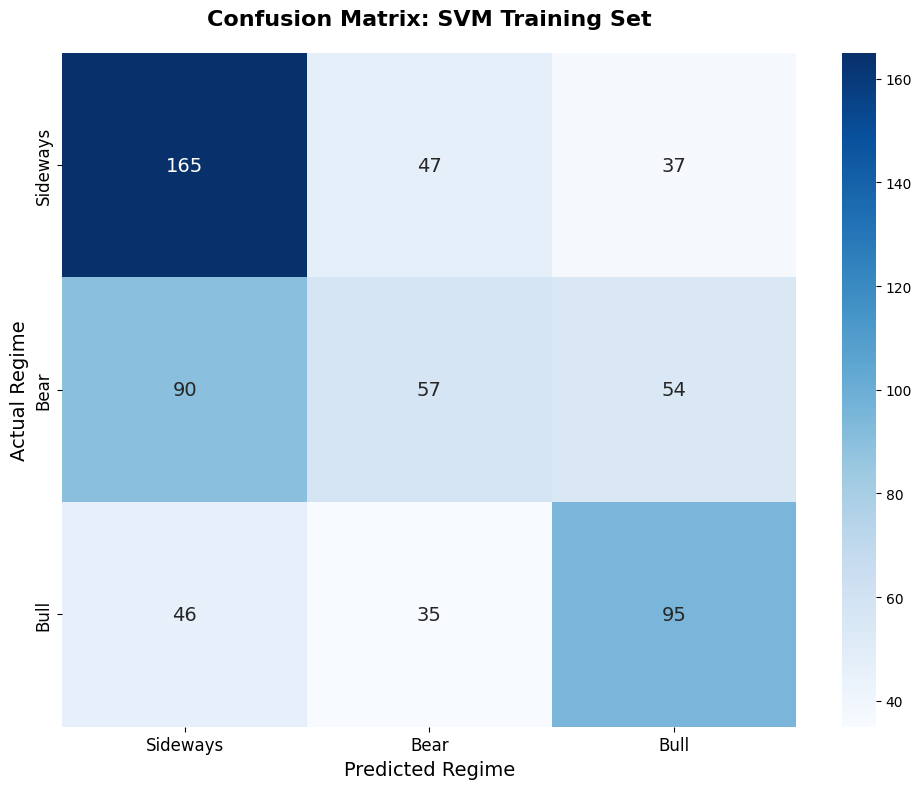

In [ ]:
final_svm_model = best_svm_model

# Make predictions
y_train_pred_svm = final_svm_model.predict(X_train_final)
y_train_prob_svm = final_svm_model.predict_proba(X_train_final)

y_test_pred_svm = final_svm_model.predict(X_test_final)
y_test_prob_svm = final_svm_model.predict_proba(X_test_final)

# Performance metrics
print("\nSVM Training Set Performance (2011-2022):")
print("-" * 50)
train_report = classification_report(df_labels_train, y_train_pred_svm,
                                      target_names=['Sideways', 'Bear', 'Bull'])
print(train_report)

# ========== CONFUSION MATRIX ONLY ==========
cm_train_svm = confusion_matrix(df_labels_train, y_train_pred_svm)

# Create a single figure for confusion matrix
plt.figure(figsize=(10, 8))

# Confusion Matrix Heatmap
sns.heatmap(cm_train_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sideways', 'Bear', 'Bull'],
            yticklabels=['Sideways', 'Bear', 'Bull'],
            annot_kws={"size": 14})

# Calculate accuracy for display
accuracy = accuracy_score(df_labels_train, y_train_pred_svm)

plt.title(f'Confusion Matrix: SVM Training Set',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Regime', fontsize=14)
plt.ylabel('Actual Regime', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Save Model

In [ ]:
if False: # Set true to export model
  model_filename = 'model_SVM_regime_prediction.json'
  best_svm_model.save_model(model_filename)